In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.neighbors import KernelDensity
from replay_trajectory_classification import ClusterlessClassifier
import matplotlib.pyplot as plt
import numpy as np
import os

from src.load_data import load_data
from src.parameters import PROCESSED_DATA_DIR


def get_all_spike_rates(epoch_key):
    animal, day, epoch = epoch_key
    data = load_data(epoch_key)
    model = ClusterlessClassifier.load_model(
        os.path.join(PROCESSED_DATA_DIR, f'{animal}_{day:02d}_{epoch:02d}_clusterless_1D_model.pkl'))

    multiunit_spikes = (np.any(~np.isnan(data['multiunit'].values), axis=1)
                        ).astype(np.float)
    is_spike = multiunit_spikes.sum(axis=1) > 0

    position_info_at_spike = data['position_info'].iloc[is_spike]
    position_info_at_spike = position_info_at_spike.loc[position_info_at_spike.speed >= 4]
    position_info = data['position_info']
    position_info = position_info.loc[position_info.speed >= 4]

    spike_kde = KernelDensity(bandwidth=6.0).fit(position_info_at_spike.linear_position[:, np.newaxis])
    spike_kde = spike_kde.score_samples(model.place_bin_centers_)

    occupancy_kde = KernelDensity(bandwidth=6.0).fit(position_info.linear_position[:, np.newaxis])
    occupancy_kde = occupancy_kde.score_samples(model.place_bin_centers_)

    mean_rate = len(position_info_at_spike.linear_position) / len(position_info.linear_position)

    rate = 500 * np.exp(np.log(mean_rate) + spike_kde - occupancy_kde)
    rate[~model.is_track_interior_] = np.nan
    
    return model.place_bin_centers_.squeeze(), rate, data['position_info'].linear_position.max()

In [3]:
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import _BRAIN_AREAS, ANIMALS

epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)
neuron_info = neuron_info.loc[
    (neuron_info.type == 'principal') &
    (neuron_info.numspikes > 100) &
    neuron_info.area.isin(_BRAIN_AREAS)]
n_neurons = (neuron_info
             .groupby(['animal', 'day', 'epoch'])
             .neuron_id
             .agg(len)
             .rename('n_neurons')
             .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
              .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB', 'wtrack']))
animal = epoch_info.reset_index('animal').set_index(epoch_info.index).animal

epoch_info = epoch_info.loc[(is_w_track & (epoch_info.n_neurons > 9)) |
                            (is_w_track & (animal == 'remy'))]

In [ ]:
all_spike_rates = {epoch_key: get_all_spike_rates(epoch_key) for epoch_key in epoch_info.index}

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load f

In [28]:
epoch_info = epoch_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)

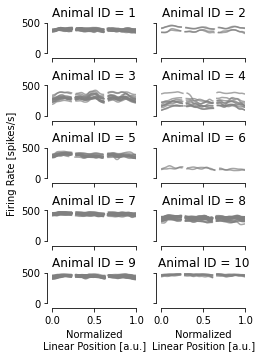

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.figure_utilities import ONE_COLUMN, PAGE_HEIGHT, save_figure
from src.parameters import FIGURE_DIR
import os


fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(ONE_COLUMN, PAGE_HEIGHT / 2))

for animal_ind, (ax, (animal, df)) in enumerate(zip(axes.flat, epoch_info.groupby('Animal ID'))):
    for epoch_key in df.index:
        if epoch_key[0] == 'cor':
            animal, day, epoch = epoch_key
            epoch_key = 'Cor', day, epoch
        place_bin_centers, rate, max_position = all_spike_rates[epoch_key]
        ax.plot(place_bin_centers / max_position, rate, color='grey', alpha=0.7)
        ax.set_title(f'Animal ID = {animal_ind + 1}')
#         ax.set_title(animal)

plt.xlim((0, 1))
plt.ylim((0, 500))
axes[-1, -1].set_xlabel('Normalized\nLinear Position [a.u.]')
axes[-1, 0].set_xlabel('Normalized\nLinear Position [a.u.]')
axes[2, 0].set_ylabel('Firing Rate [spikes/s]')
sns.despine(offset=5)

fig_dir = os.path.join(FIGURE_DIR, 'Figure2-supplemental3')
os.makedirs(fig_dir, exist_ok=True)
save_figure(os.path.join(fig_dir, 'neural_place_coverage'))